           CRIM          ZN      INDUS      CHAS       NOX        RM  \
mean   3.611874   11.211934  11.083992  0.069959  0.554695  6.284634   
std    8.720192   23.388876   6.835896  0.255340  0.115878  0.702617   
min    0.006320    0.000000   0.460000  0.000000  0.385000  3.561000   
max   88.976200  100.000000  27.740000  1.000000  0.871000  8.780000   

             AGE        DIS        RAD         TAX    PTRATIO           B  \
mean   68.518519   3.795043   9.549407  408.237154  18.455534  356.674032   
std    27.999513   2.105710   8.707259  168.537116   2.164946   91.294864   
min     2.900000   1.129600   1.000000  187.000000  12.600000    0.320000   
max   100.000000  12.126500  24.000000  711.000000  22.000000  396.900000   

          LSTAT       MEDV  
mean  12.715432  22.532806  
std    7.155871   9.197104  
min    1.730000   5.000000  
max   37.970000  50.000000  


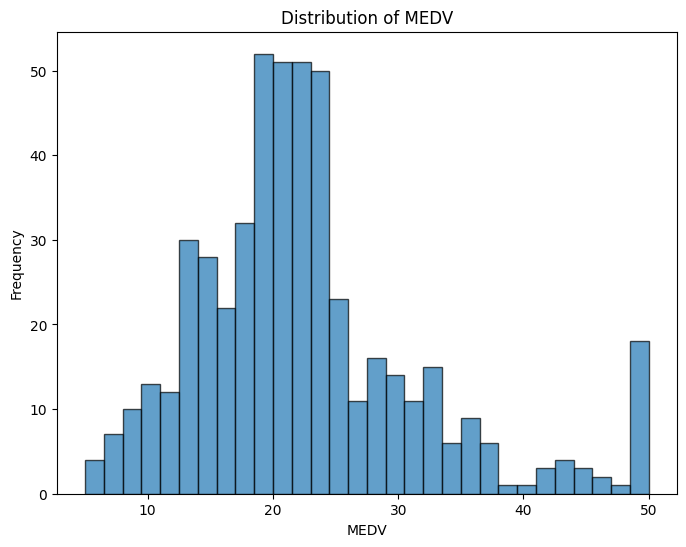

In [12]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# # Load the dataset
# data = pd.read_csv('../../data/external/HousingData.csv')

# # Describe the dataset
# description = data.describe()
# print(description)

# # Plot the distribution of the target variable
# plt.hist(data['MEDV'], bins=30)
# plt.title('Distribution of MEDV')
# plt.xlabel('MEDV')
# plt.ylabel('Frequency')
# plt.show()

# # Partition the dataset
# X = data.drop('MEDV', axis=1)
# y = data['MEDV']
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# # Normalize and standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import numpy as np

# Load the dataset and display basic statistics
housing_data = pd.read_csv("../../data/external/HousingData.csv")
stats_summary = housing_data.agg(['mean', 'std', 'min', 'max'])
print(stats_summary)

# Plot the distribution of the target variable (MEDV)
medv_values = housing_data['MEDV']

plt.figure(figsize=(8, 6))
plt.hist(medv_values, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('MEDV')
plt.ylabel('Frequency')
plt.title('Distribution of MEDV')
plt.show()

# Split the dataset into training (70%), validation (15%), and test (15%) sets
features = housing_data.drop(columns=['MEDV'])
target = housing_data['MEDV']
target = np.array(target).reshape(-1, 1)

X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Normalize the features using Min-Max scaling
min_max_scaler = MinMaxScaler()
X_train_normalized = min_max_scaler.fit_transform(X_train_imputed)
X_val_normalized = min_max_scaler.transform(X_val_imputed)
X_test_normalized = min_max_scaler.transform(X_test_imputed)

# Standardize the features to have mean=0 and std=1 using Z-score scaling
standard_scaler = StandardScaler()
X_train_standardized = standard_scaler.fit_transform(X_train_imputed)
X_val_standardized = standard_scaler.transform(X_val_imputed)
X_test_standardized = standard_scaler.transform(X_test_imputed)



In [16]:
import wandb
import numpy as np

class MLPRegressor:
    def __init__(self, num_hidden_layers=1, num_neurons=64, activation='relu', learning_rate=0.01):
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons
        self.activation = activation
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []
        self.activations = [self.activation] * (num_hidden_layers + 1)
        self.activations[-1] = 'linear'  # Use linear activation for regression

    def initialize_weights_and_biases(self, input_dim):
        layer_sizes = [input_dim] + [self.num_neurons] * self.num_hidden_layers + [1]  # Regression has one output
        for i in range(1, len(layer_sizes)):
            input_size, output_size = layer_sizes[i - 1], layer_sizes[i]
            weight = np.random.randn(input_size, output_size) * 0.01
            bias = np.zeros((1, output_size))
            self.weights.append(weight)
            self.biases.append(bias)

    def compute_loss(self, y_true, y_pred):
        m = len(y_true)
        loss = 0.5 * np.mean((y_true - y_pred) ** 2)
        return loss

    def activate(self, x, activation_type):
        if activation_type == 'relu':
            return np.maximum(0, x)
        elif activation_type == 'sigmoid':
            x = np.clip(x, -500, 500)
            return 1 / (1 + np.exp(-x))
        elif activation_type == 'tanh':
            return np.tanh(x)
        elif activation_type == 'linear':
            return x

    def d_relu(self, x):
        return np.where(x > 0, 1, 0)

    def d_sigmoid(self, x):
        return x * (1 - x)

    def d_tanh(self, x):
        return 1 - np.tanh(x) ** 2
    
    def d_linear(self, x):
        return np.ones_like(x)

    def forward_propagation(self, x):
        z_values = []
        a_values = [x]
        for i in range(self.num_hidden_layers):
            z = np.dot(a_values[i], self.weights[i]) + self.biases[i]
            a = self.activate(z, self.activations[i])
            z_values.append(z)
            a_values.append(a)

        # Output layer with linear activation for regression
        z = np.dot(a_values[-1], self.weights[-1]) + self.biases[-1]
        a = self.activate(z, self.activations[-1])
        z_values.append(z)
        a_values.append(a)

        return z_values, a_values

    def backward_propagation(self, x, y):
        m = x.shape[0]
        z_values, a_values = self.forward_propagation(x)
        gradients = [None] * (self.num_hidden_layers + 1)

        # Compute gradient of the output layer
        gradients[-1] = (a_values[-1] - y) / m

        # Backpropagate through hidden layers
        for i in reversed(range(self.num_hidden_layers)):
            if self.activations[i] == 'relu':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_relu(a_values[i + 1])
            elif self.activations[i] == 'sigmoid':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_sigmoid(a_values[i + 1])
            elif self.activations[i] == 'tanh':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_tanh(a_values[i + 1])
            elif self.activations[i] == 'linear':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_linear(a_values[i + 1])

        # Compute gradients for weights and biases
        dW = [None] * (self.num_hidden_layers + 1)
        db = [None] * (self.num_hidden_layers + 1)
        for i in range(self.num_hidden_layers + 1):
            dW[i] = np.dot(a_values[i].T, gradients[i])
            db[i] = np.sum(gradients[i], axis=0)

        return dW, db

    def predict(self, x):
        _, y_pred = self.forward_propagation(x)
        return y_pred[-1]

    def sgd(self, x, y, num_epochs=1000):
        input_dim = x.shape[1]
        self.initialize_weights_and_biases(input_dim)

        m = x.shape[0]  # Number of training samples

        for epoch in range(num_epochs):
            for i in range(m):
                # Select a random training sample (Stochastic Gradient Descent)
                random_index = np.random.randint(0, m)
                x_sample = x[random_index:random_index + 1]
                y_sample = y[random_index:random_index + 1]

                dW, db = self.backward_propagation(x_sample, y_sample)

                for j in range(self.num_hidden_layers + 1):
                    self.weights[j] -= self.learning_rate * dW[j]
                    self.biases[j] -= self.learning_rate * db[j]

                _, y_pred = self.forward_propagation(x)
                loss = self.compute_loss(y, y_pred[-1])
                wandb.log({f"Loss Optimizer=SGD Epochs={num_epochs} Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": loss})

            if (epoch + 1) % 100 == 0:
                print(f"SGD Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")

        print("SGD Training complete!")
        
    def batch_gradient_descent(self, x, y, batch_size=32, num_epochs=1000):
        input_dim = x.shape[1]
        self.initialize_weights_and_biases(input_dim)
        
        m = x.shape[0]  # Number of training samples
        
        for epoch in range(num_epochs):
            for i in range(0, m, batch_size):
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                
                dW, db = self.backward_propagation(x_batch, y_batch)
                
                for j in range(self.num_hidden_layers + 1):
                    self.weights[j] -= self.learning_rate * dW[j]
                    self.biases[j] -= self.learning_rate * db[j]
            
            _, y_pred = self.forward_propagation(x)
            loss = self.compute_loss(y, y_pred[-1])
            wandb.log({f"Loss Optimizer=Batch Epochs={num_epochs} Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": loss})
            
            if (epoch + 1) % 100 == 0:
                print(f"Batch Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")
        
        print("Batch Training complete!")

    def mini_batch_gradient_descent(self, x, y, batch_size=32, num_epochs=1000):
        input_dim = x.shape[1]
        self.initialize_weights_and_biases(input_dim)
        
        m = x.shape[0]  # Number of training samples
        
        for epoch in range(num_epochs):
            indices = np.arange(m)
            np.random.shuffle(indices)
            x_shuffled = x[indices]
            y_shuffled = y[indices]
            
            for i in range(0, m, batch_size):
                x_batch = x_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                dW, db = self.backward_propagation(x_batch, y_batch)
                
                for j in range(self.num_hidden_layers + 1):
                    self.weights[j] -= self.learning_rate * dW[j]
                    self.biases[j] -= self.learning_rate * db[j]
            
            _, y_pred = self.forward_propagation(x)
            loss = self.compute_loss(y, y_pred[-1])
            wandb.log({f"Loss Optimizer=Mini_Batch Epochs={num_epochs} Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": loss})
            
            if (epoch + 1) % 100 == 0:
                print(f"Mini_Batch Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")
        
        print("Mini_Batch Training complete!")
    
    def evaluate_model(self,x,y):
        _, y_pred = self.forward_propagation(x)
        loss = self.compute_loss(y, y_pred[-1])
        wandb.log({f"Loss Optimizer=Mini_Batch Learning Rate={self.learning_rate} Num_hidden_layers={self.num_hidden_layers} Num_neurons={self.num_neurons} Activation={self.activation}": loss})

In [17]:
from itertools import product
from sklearn.metrics import mean_squared_error, r2_score
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable
from sklearn.metrics import classification_report


# Initialize and train the model
wandb.init(project="regression_example_testing", entity="vishnuvarun-iiit-hyderabad")
best_mse = float('inf')
best_model = None
best_hyperparameters = None

# Define hyperparameters to tune
# learning_rates = [0.01, 0.001]
# num_epochs = [500, 1000]
# num_hidden_layers = [1, 2]
# num_neurons = [64, 128]
# activations = ['relu', 'sigmoid','tanh']
# optimizers = ['sgd', 'batch_gradient_descent', 'mini_batch_gradient_descent']

# # Define hyperparameters to tune
learning_rates = [0.01]
num_epochs = [1000]
num_hidden_layers = [2]
num_neurons = [5]
activations = ['sigmoid']
optimizers = ['sgd']

metrics_table = PrettyTable()
metrics_table.field_names = ["Learning Rate", "Number of Epochs", "Number of Hidden Layers", "Number of Neurons", "Activation Function", "Optimizer","MSE","RMSE","R-Squared"]


# Initialize a dictionary to collect metrics and hyperparameters
hyperparameter_metrics = {
    'learning_rate': [],
    'num_epochs': [],
    'num_hidden_layers': [],
    'num_neurons': [],
    'activation': [],
    'optimizer': [],
    'MSE': [],
    'RMSE': [],
    'R2': [],
}

# Perform hyperparameter tuning
for lr, epochs, num_layers, num_neurons, activation, optimizer in product(learning_rates, num_epochs, num_hidden_layers, num_neurons, activations, optimizers):
    
    config = {
        'learning_rate': lr,
        'num_epochs': epochs,
        'num_hidden_layers': num_layers,
        'num_neurons': num_neurons,
        'activation': activation,
        'optimizer': optimizer
    }
    wandb.config.update(config)

    model = MLPRegressor(
        num_hidden_layers=num_layers,
        num_neurons=num_neurons,
        activation=activation,
        learning_rate=lr,
    )
    model.sgd(X_train_standardized, y_train, num_epochs=epochs)
    model.evaluate_model(X_val_standardized,y_val)
    y_pred_val = model.predict(X_val_standardized)
    
    #Calculate and report metrics
    mse = mean_squared_error(y_val, y_pred_val)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_val, y_pred_val)
    
    if mse < best_mse:  # We want to minimize MSE
        best_mse = mse
        best_model = model
        best_hyperparameters = {
            'learning_rate': lr,
            'num_epochs': epochs,
            'num_hidden_layers': num_layers,
            'num_neurons': num_neurons,
            'activation': activation,
            'optimizer': optimizer
        }
        
    metrics_table.add_row([lr, epochs, num_layers, num_neurons, activation, optimizer, mse, rmse, r2])
    
    hyperparameter_metrics['learning_rate'].append(lr)
    hyperparameter_metrics['num_epochs'].append(epochs)
    hyperparameter_metrics['num_hidden_layers'].append(num_layers)
    hyperparameter_metrics['num_neurons'].append(num_neurons)
    hyperparameter_metrics['activation'].append(activation)
    hyperparameter_metrics['optimizer'].append(optimizer)
    hyperparameter_metrics['MSE'].append(mse)
    hyperparameter_metrics['RMSE'].append(rmse)
    hyperparameter_metrics['R2'].append(r2)


print("Hyperparameters for the Best Model:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

print(metrics_table)

y_pred_test = best_model.predict(X_test_standardized)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = math.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)
report = f"MSE: {mse_test:.4f}\nRMSE: {rmse_test:.4f}\nR-squared: {r2_test:.4f}"

print("Regression Metrics on Test Set:")
print(report)


# Finish the W&B run
wandb.run.finish()


SGD Epoch 100/1000, Loss: 5.5431
SGD Epoch 200/1000, Loss: 3.3569
SGD Epoch 300/1000, Loss: 3.7936
SGD Epoch 400/1000, Loss: 3.6433
SGD Epoch 500/1000, Loss: 3.7231
SGD Epoch 600/1000, Loss: 3.3090
SGD Epoch 700/1000, Loss: 3.2350
SGD Epoch 800/1000, Loss: 3.4893
SGD Epoch 900/1000, Loss: 3.2599
SGD Epoch 1000/1000, Loss: 3.4401
SGD Training complete!
Hyperparameters for the Best Model:
learning_rate: 0.01
num_epochs: 1000
num_hidden_layers: 2
num_neurons: 5
activation: sigmoid
optimizer: sgd
+---------------+------------------+-------------------------+-------------------+---------------------+-----------+--------------------+-------------------+-------------------+
| Learning Rate | Number of Epochs | Number of Hidden Layers | Number of Neurons | Activation Function | Optimizer |        MSE         |        RMSE       |     R-Squared     |
+---------------+------------------+-------------------------+-------------------+---------------------+-----------+--------------------+---------

wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 